# Lasso Regression

In [1]:
from sklearn import linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
x_tr=pd.read_csv('../X_train.csv', sep=',')
y_tr=pd.read_csv('../y_train.csv', sep=',')
x_te=pd.read_csv('../X_test.csv', sep=',')

# Initial empty prediction dataframe
index = np.arange(len(x_te.iloc[:,0]))
columns = ["Id"]
rows = len(x_te.iloc[:,0])
data = np.arange(rows, dtype=int)
prediction = pd.DataFrame(data, columns=columns)

# Ignore deprecation warnings (makes results hard to read)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [34]:
#Lasso regression pipeline (l1 regularisation)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
# Scale twice, as poly features will return values that need to be rescaled
pipe = Pipeline([("scaler1", StandardScaler()),
                  ("poly", PolynomialFeatures(degree=5)),
                  ("scaler2", StandardScaler()),
                  ("lasso", linear_model.ElasticNetCV(l1_ratio=1.0, cv=3, max_iter=1e6))
                 ])

# Perform a grid search to find the best alphas according to neg_mean_absolute_error scoring
param_grid = {
    'lasso__alphas': list(np.linspace(0.1, 10.0, 50).reshape(50,1))
}
search = GridSearchCV(pipe, param_grid, cv=5, error_score="raise", scoring="neg_mean_squared_error")
print("Best Params:" + str(search.fit(x_tr, y_tr["PRP"]).best_params_))

model = search.fit(x_tr, y_tr["PRP"]).best_estimator_

prediction["PRP"] = np.around(model.predict(x_te)).astype(int)
print(prediction.to_string(index=False))
prediction.to_csv("n_lr_results.csv", index=False)
print(model.score(x_tr, y_tr["PRP"])) # R2 scoring for good measure

Best Params:{'lasso__alphas': array([4.94897959])}
 Id   PRP
  0    45
  1   154
  2    21
  3   388
  4    55
  5    24
  6    73
  7    32
  8    42
  9    25
 10    33
 11    26
 12   263
 13    48
 14   149
 15    35
 16    36
 17    46
 18    34
 19   152
 20    97
 21    29
 22    65
 23    22
 24   154
 25   116
 26    75
 27   382
 28    30
 29   297
 30   114
 31    16
 32    71
 33   178
 34    43
 35  1011
 36    24
 37   382
 38    43
 39    36
 40   114
0.9434450552813203


# Experiments

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# Scale data MinMax or Standard
def scale(type="standard", x_train=x_tr, x_test=x_te):
    if type=="minmax":
        scaler_x = MinMaxScaler()
    elif type=="standard":
        scaler_x = StandardScaler()
    elif type=="robust":
        scaler_x = RobustScaler()
        
    scaler_x = scaler_x.fit(x_train)  # fit only on training data
    x_train = scaler_x.transform(x_train)
    x_test = scaler_x.transform(x_test)  # apply same transformation to test data
    
    return x_train, x_test, scaler_x


In [7]:
# Generate polynomial features
from sklearn.preprocessing import PolynomialFeatures
def poly(features=3, x_train=x_tr, x_test=x_te):

    poly = PolynomialFeatures(features)

    x_train = poly.fit_transform(x_train)
    x_test = poly.fit_transform(x_test)
    
    return x_train, x_test

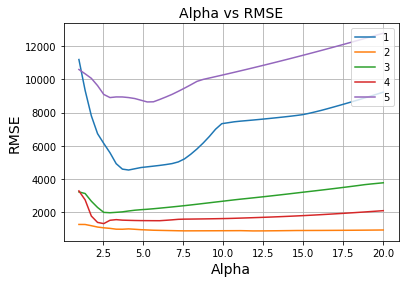

In [14]:
from sklearn.pipeline import Pipeline

# Visualising how MSE varies with different alpha values
cv = 5
pipe = Pipeline([("scaler1", StandardScaler()),
                  ("poly", PolynomialFeatures(degree=5)),
                  ("scaler2", StandardScaler()),
                  ("lasso", linear_model.LassoCV(alphas=np.linspace(1, 20.0, 50), cv=cv, max_iter=1e6))
                 ])

model = pipe.fit(x_tr, y_tr["PRP"])

for i in range(cv):
    plt.plot(pipe["lasso"].alphas_, pipe["lasso"].mse_path_[:,i], label=i+1)

plt.title('Alpha vs RMSE', fontsize=14)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [37]:
#Ridge regression pipeline (l2 regularisation)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# Scale twice, as poly features will return values that need to be rescaled
pipe = Pipeline([("scale1", StandardScaler()),
                  ("poly", PolynomialFeatures(degree=3)), # degree > 3 returns negative results
                  ("scale2", StandardScaler()),
                  ("ridge", linear_model.RidgeCV(cv=5))
                 ])

# Perform a grid search to find the best alphas according to neg_mean_absolute_error scoring
param_grid = {
    'ridge__alphas': list(np.linspace(0.1, 10.0, 50).reshape(50,1))
}
search = GridSearchCV(pipe, param_grid, cv=5, error_score="raise", scoring="neg_mean_squared_error")
print("Best Params:" + str(search.fit(x_tr, y_tr["PRP"]).best_params_))
print(search.grid_scores_)

model = search.fit(x_tr, y_tr["PRP"]).best_estimator_

prediction["PRP"] = np.around(model.predict(x_te)).astype(int)
print(prediction.to_string(index=False))
prediction.to_csv("n_rr_results.csv", index=False)
print(model.score(x_tr, y_tr["PRP"])) # R2 scoring for good measure

Best Params:{'ridge__alphas': array([10.])}


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [32]:
# Iteratively find the best polynomial features degree
def get_pipe(degree):
    pipe = Pipeline([("scaler1", StandardScaler()),
                      ("poly", PolynomialFeatures(degree=degree)),
                      ("scaler2", StandardScaler()),
                      ("lasso", linear_model.LassoCV(alphas=np.linspace(1, 20.0, 50), cv=cv, max_iter=1e6))
                     ])
    return pipe

degree = 5
for i in range(degree):
    print("degree=" + str(i+1))
    pipe = get_pipe(i+1)
    # Perform a grid search to find the best alphas according to neg_mean_absolute_error scoring
    param_grid = {
        'lasso__alphas': list(np.linspace(0.1, 10.0, 50).reshape(50,1))
    }
    search = GridSearchCV(pipe, param_grid, cv=5, error_score="raise", scoring="neg_mean_squared_error")
    print("Best Params:" + str(search.fit(x_tr, y_tr["PRP"]).best_params_))

    model = search.fit(x_tr, y_tr["PRP"]).best_estimator_

    prediction["PRP"] = np.around(model.predict(x_te)).astype(int)
    prediction.to_csv("n_lr_results.csv", index=False)
    print(model.score(x_tr, y_tr["PRP"])) # R2 scoring for good measure


degree=1
Best Params:{'lasso__alphas': array([10.])}
0.8729039158573217
degree=2
Best Params:{'lasso__alphas': array([6.56530612])}
0.9407159409248527
degree=3
Best Params:{'lasso__alphas': array([3.33265306])}
0.9456177864114023
degree=4
Best Params:{'lasso__alphas': array([4.34285714])}
0.944241649967071
degree=5
Best Params:{'lasso__alphas': array([4.94897959])}
0.9434450552813203


In [26]:
# Calculate MSE

from sklearn.metrics import mean_squared_error
from math import sqrt

def calc_rmse(real, predict):
    mse = mean_squared_error(real, predict)
    rmse = sqrt(mse)

    return rmse

In [28]:
# Effect on RMSE
real = [20, 40, 300]
predict = [20, 40, 300]
predict[0] *= 2
print(calc_rmse(real, predict))

predict = [20, 40, 300]
predict[2] *= 2
print(calc_rmse(real, predict))

assert()
# Larger the number, the worse the penalty

11.547005383792516
173.20508075688772
